In [32]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
import os

In [16]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [17]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [18]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


In [19]:
words[1:10]

['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']

In [20]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


In [21]:
[print(i) for i in range(2)]

0
1


[None, None]

In [22]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    '''
    parameters:
        batch_size: the size of the batch
        num_skips: for one word, how many words should be selected as correspondance lables.
        skip_window: the range near the target word where some random word can be selected.
    function:
        在window的范围内, 随机选择除了target的词的skip个其他词汇, 构成label.
    '''
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span) # deque is another kind of list, more efficient one.
    for _ in range(span): # buffer在span这个窗口下面, 从data顺序取出span个单词, buffer变成了一个五个单词的小data
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips): # 取商
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window] # what is meaning of the index. (i * num_skips + j)
            labels[i * num_skips + j, 0] = buffer[target]
            # batch = ['target1',...,'target2' ], 
            # labels = ['random word collected from target1', ..., 'random word collected from 'target 2']
    buffer.append(data[data_index]) # data_index changes every round. After one round index+=span
    data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'originated', 'originated', 'originated', 'originated', 'originated', 'originated']
    labels: ['anarchism', 'as', 'as', 'anarchism', 'as', 'anarchism', 'anarchism', 'as']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'as', 'as', 'as', 'as']
    labels: ['term', 'a', 'originated', 'anarchism', 'originated', 'term', 'anarchism', 'a']


In [23]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 3 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

# with graph.as_default(), tf.device('/cpu:0'):
with graph.as_default():
    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
    # Variables.
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    # -1 to 1 's nomal distribution with shape (N, m_e)
    softmax_weights = tf.Variable(tf.truncated_normal(
        [vocabulary_size, embedding_size],stddev=1.0 / math.sqrt(embedding_size)))
    #  
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [24]:
num_steps = 100001

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.Session(graph=graph, config=config) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(
          batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l # This is "l" for loss not the number 1
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
          # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 6.582233
Nearest to time: cassava, interventionist, veterinarians, stele, blackwell, lungs, knighted, pulsar,
Nearest to four: dassault, vestiges, relegation, ystok, insuring, crossbow, identifiable, refutations,
Nearest to he: washington, tenor, varying, potatoes, jupiter, eo, retina, cm,
Nearest to of: rium, metalwork, invests, rpgs, corsair, transporter, braking, nickel,
Nearest to may: castles, benitez, syphilis, subordinated, changeover, maslow, resentment, unclassified,
Nearest to nine: guests, sabbatical, retailer, nbc, carnarvon, counsel, white, arrigo,
Nearest to two: gonzalez, seele, mechanic, server, stitched, solemnity, matte, roman,
Nearest to war: adrienne, feb, othon, scottish, ib, ninhursag, unchecked, cooks,
Nearest to more: distributive, selwyn, dune, step, aleman, armchair, connoisseur, encircles,
Nearest to such: fleischmann, morpork, deal, nobleman, cert, murdered, staggered, teas,
Nearest to most: temporarily, fare, vito, ignacy

Average loss at step 52000: 10.673173
Average loss at step 54000: 10.843607
Average loss at step 56000: 10.588732
Average loss at step 58000: 10.314714
Average loss at step 60000: 10.182972
Nearest to time: cormac, permeability, in, mandating, frazier, storey, for, landowner,
Nearest to four: nine, two, the, six, eight, to, s, zero,
Nearest to he: the, a, to, for, two, was, s, his,
Nearest to of: UNK, that, the, in, a, s, and, for,
Nearest to may: not, domitia, to, attributable, were, a, fdl, gul,
Nearest to nine: two, four, in, one, zero, s, seven, a,
Nearest to two: the, nine, UNK, zero, of, in, to, one,
Nearest to war: humanists, streams, kiwifruit, naturalistic, consternation, fascist, or, interventionism,
Nearest to more: for, also, of, UNK, this, that, a, to,
Nearest to such: plugging, originality, buzzard, fictitious, tangier, joke, irgun, for,
Nearest to most: as, the, a, negatives, edmund, sphinx, gamma, be,
Nearest to a: UNK, the, that, of, as, s, for, in,
Nearest to years: w

In [25]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

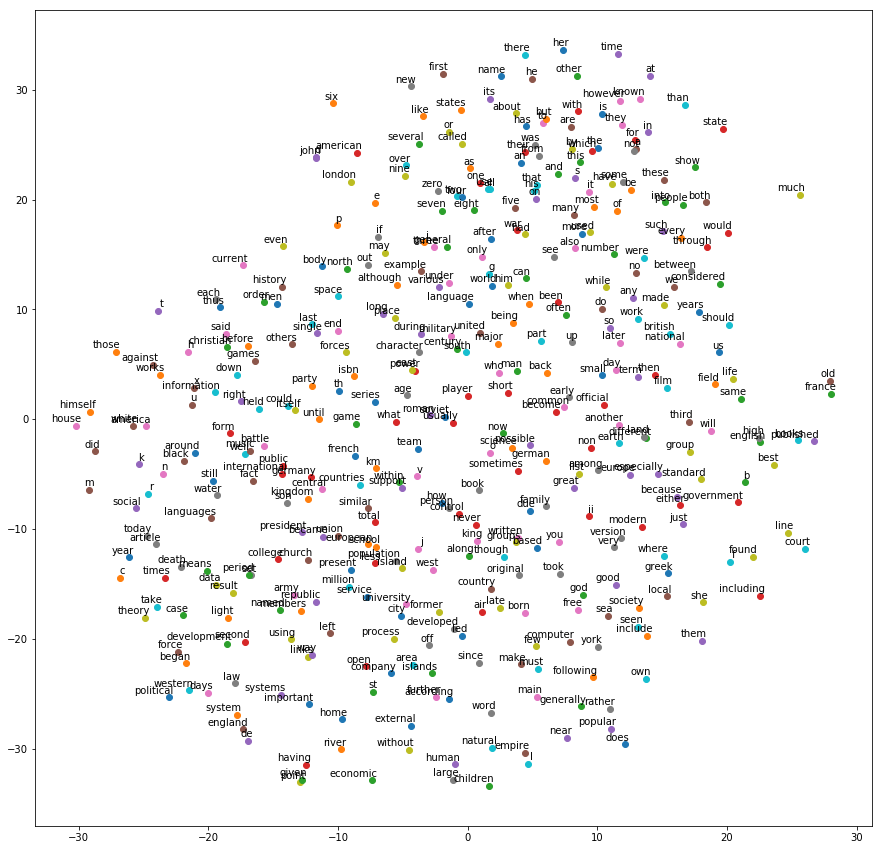

In [26]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)


In [27]:
embeddings?

In [28]:
embed.shape

TensorShape([Dimension(128), Dimension(128)])

cbow 的区别在于他的输出的出入的数据

1. 输入和输出刚好和skip-gram相反
2. 其他的过程一样

1. 模型结构
- softmax

Initialized
Average loss at step 0: 10.813389
Average loss at step 2000: 7.473708
Average loss at step 4000: 6.415029
Average loss at step 6000: 6.377375
Average loss at step 8000: 5.926403
Average loss at step 10000: 5.998007
Average loss at step 12000: 5.793313
Average loss at step 14000: 5.412465
Average loss at step 16000: 5.538089
Average loss at step 18000: 5.433532
Average loss at step 20000: 5.535992
Average loss at step 22000: 5.351335
Average loss at step 24000: 5.241660
Average loss at step 26000: 5.443180
Average loss at step 28000: 5.163128
Average loss at step 30000: 5.734656
Average loss at step 32000: 5.725011
Average loss at step 34000: 5.559621
Average loss at step 36000: 5.668837
Average loss at step 38000: 5.708571
Average loss at step 40000: 5.586493
Average loss at step 42000: 5.649109
Average loss at step 44000: 5.576013
Average loss at step 46000: 5.551544
Average loss at step 48000: 5.398560
Average loss at step 50000: 5.524200
Average loss at step 52000: 5.404

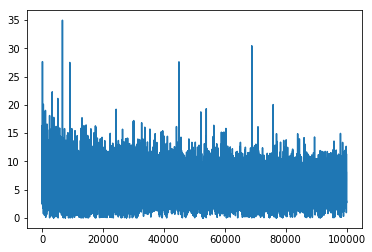

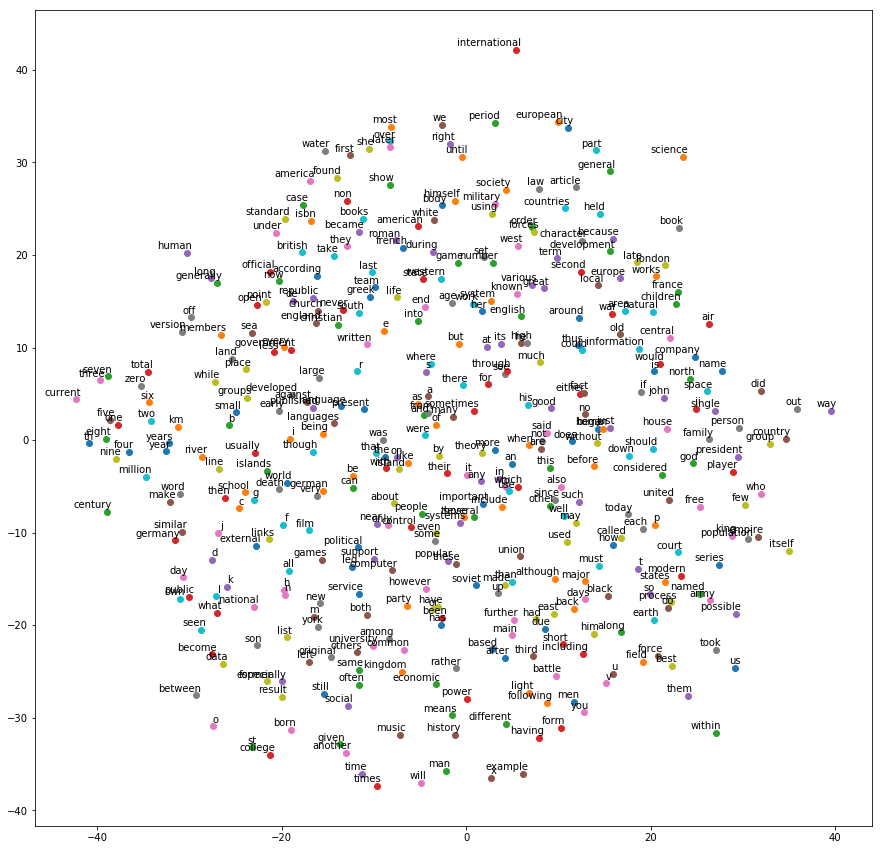

In [51]:
with tf.Session(graph=graph, config=config) as session:
    # config是为了把内存空出来
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    loss_list = []
    for step in range(num_steps):
        batch_labels, batch_data = generate_batch(
          batch_size, num_skips, skip_window)
        batch_labels = batch_labels.reshape((batch_size, 1))
        batch_data = batch_data.reshape((batch_size, ))
        # 交换labels和data
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        loss_list.append(l)
        average_loss += l # This is "l" for loss not the number 1
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
          # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
#         if step % 10000 == 0:
#             sim = similarity.eval()
#             for i in range(valid_size):
#                 valid_word = reverse_dictionary[valid_examples[i]]
#                 top_k = 8 # number of nearest neighbors
#                 nearest = (-sim[i, :]).argsort()[1:top_k+1]
#                 log = 'Nearest to %s:' % valid_word
#                 for k in range(top_k):
#                     close_word = reverse_dictionary[nearest[k]]
#                     log = '%s %s,' % (log, close_word)
#                 print(log)
                
    final_embeddings = normalized_embeddings.eval()

    num_points = 400
    pylab.plot(loss_list)

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

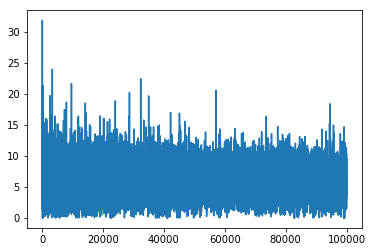

In [37]:
pylab.plot(loss_list, '-')

In [45]:
[print(i) for i in range(0,9, 3)]

0
3
6


[None, None, None]

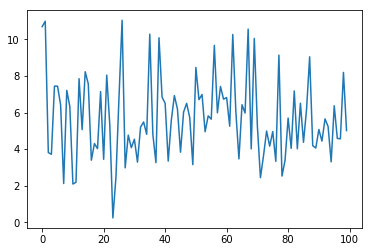

In [55]:
pylab.plot(np.array(loss_list[0:100000]).reshape((100, 1000))[:,1])